In [70]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shap
from ultralytics import YOLO
import random
import cv2

import tensorflow as tf

### Step 1: Random image selection from test dataset

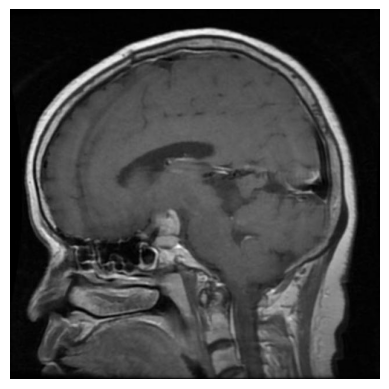

Image Name: Tr-pi_0242_jpg.rf.4d873e77a42417473c39d36f43d708e6.jpg
Class Prefix: pi
Tumor Class: Pituitary


In [64]:
test_image_dir = "Labeled-MRI-Brain-Tumor-Dataset-1/test/images"

image_files = os.listdir(test_image_dir)

random_image = random.choice(image_files)


# Plot selected random image
random_image_path = os.path.join(test_image_dir, random_image)

image = Image.open(random_image_path)
plt.imshow(image)
plt.axis("off")
plt.show()




# Retrieve original label from images'name

class_mapping = {
    "gl": "Glioma",
    "me": "Meningioma",
    "no": "No Tumor",
    "pi": "Pituitary"
}

prefix = random_image.split('-')[1].split('_')[0]
tumor_class = class_mapping.get(prefix, "Unknown")

print(f"Image Name: {random_image}")
print(f"Class Prefix: {prefix}")
print(f"Tumor Class: {tumor_class}")

### Step 2: Use random image file as the input of CNN model to predict its class

In [65]:
# Load the Pre-trained CNN Model ---
cnn_checkpoint_dir = './checkpoints'
cnn_model_path = os.path.join(cnn_checkpoint_dir, 'best_model.keras')
cnn_model = tf.keras.models.load_model(cnn_model_path)

In [72]:
# Preprocess the selected image for the CNN model
image_size = (128, 128)
image = image.resize(image_size)
image_array = np.array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


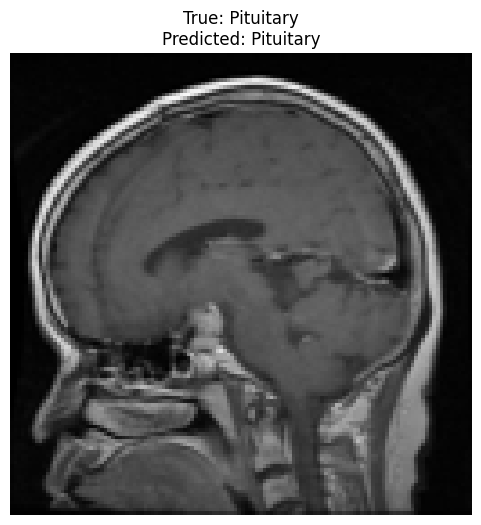

Random Image: Tr-pi_0242_jpg.rf.4d873e77a42417473c39d36f43d708e6.jpg
True Class: Pituitary
Predicted Class: Pituitary
Confidence: 1.00
Accuracy Metric: 1.00


In [ ]:
# Make a prediction using the CNN model
prediction = cnn_model.predict(image_array)
predicted_class_index = np.argmax(prediction)
predicted_class = list(class_mapping.values())[predicted_class_index]

# Retrieve the true class index
true_class_index = list(class_mapping.keys()).index(prefix)

# Use Keras metrics to calculate accuracy
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
true_class_tensor = tf.constant([true_class_index])
predicted_probs_tensor = tf.constant(prediction)

# Update and compute accuracy
accuracy_metric.update_state(true_class_tensor, predicted_probs_tensor)
accuracy = accuracy_metric.result().numpy()

# Display the results
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"True: {tumor_class}\nPredicted: {predicted_class}")
plt.show()

# Print prediction result
print(f"Random Image: {random_image}")
print(f"True Class: {tumor_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {prediction[0][predicted_class_index]:.2f}")
print(f"Accuracy Metric: {accuracy:.2f}")

### Step 3: Use ExplainableAI to justify

In [86]:
import shap

shap.initjs();

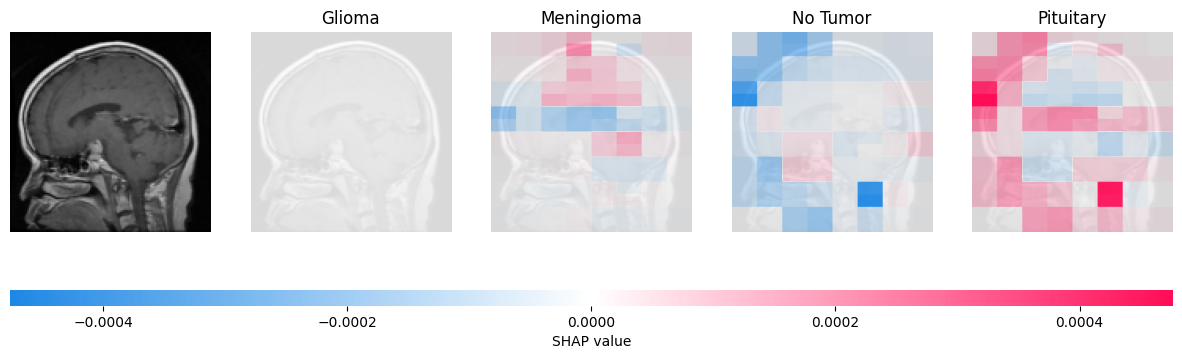

In [110]:
# Assume image_array is already prepared, and cnn_model is loaded

# Define the masker (masking partitions of the input image)
masker = shap.maskers.Image("blur(128,128)", image_array.shape[1:])  # image_array[0].shape gives (128, 128, 3)

# Initialize the SHAP Explainer with the model and the masker
explainer = shap.Explainer(cnn_model, masker, output_names=list(class_mapping.values()))

# Compute SHAP values for the image
shap_values = explainer(image_array)  # No need for batch_size and outputs here

# Visualize the SHAP explanation for the image
shap.image_plot(shap_values, image_array)

### Step 4: Detect the tumor location

In [111]:
# --- Step 2: Load the Pre-trained YOLOv8 Model and Dataset ---
yolo_checkpoint_dir = './checkpoints'
yolo_model_path = os.path.join(yolo_checkpoint_dir, 'yolo8_model.pt')
model = YOLO(yolo_model_path)


image 1/1 /home/gokhan/code/joelbrice/brainmap/notebooks/Labeled-MRI-Brain-Tumor-Dataset-1/test/images/Tr-pi_0242_jpg.rf.4d873e77a42417473c39d36f43d708e6.jpg: 640x640 1 Pituitary, 110.0ms
Speed: 1.8ms preprocess, 110.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


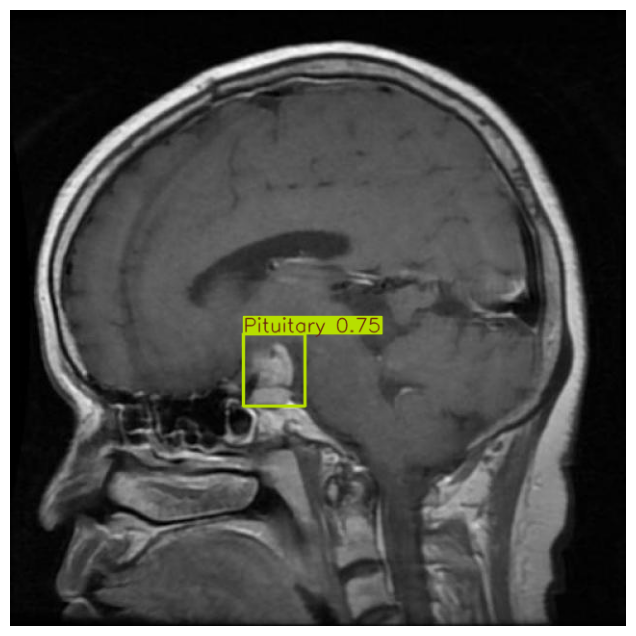

In [115]:
tumor_detection= model.predict(source=random_image_path)

predicted_image = tumor_detection[0].plot()

plt.figure(figsize=(8, 8))
plt.imshow(predicted_image)
plt.axis('off')
plt.show()